In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

Util-функции

In [2]:
def draw_plots(rows, cols, width, height, subplot_data, legend_loc="best", legend_fontsize="small"):
    fig, axes = plt.subplots(rows, cols, figsize=(width, height))
    axes = axes.flatten() if rows * cols > 1 else [axes]

    flat_data = [item for row in subplot_data for item in row]

    for idx, data in enumerate(flat_data):
        if idx >= len(axes):
            raise ValueError(f"Too many subplots provided in 'subplot_data': expected at most {rows * cols}, got more.")
        if not data:
            continue

        ax = axes[idx]

        (
            x_arrays, y_arrays,
            labels,
            x_label, y_label,
            colors, linestyles,
            linewidth, markers,
            markersizes, title,
            markerevery
        ) = data + [None] * (12 - len(data))

        num_plots = len(y_arrays)

        for i in range(num_plots):
            x = x_arrays[i]
            y = y_arrays[i]

            label = labels[i] if labels and i < len(labels) else None
            color = colors[i] if colors and i < len(colors) else None
            linestyle = linestyles[i] if linestyles and i < len(linestyles) else '-'
            lw = linewidth[i] if linewidth and i < len(linewidth) else 2
            marker = markers[i] if markers and i < len(markers) else None
            markersize = markersizes[i] if markersizes and i < len(markersizes) else None
            mevery = markerevery[i] if markerevery and i < len(markerevery) else None

            ax.plot(x, y,
                    label=label,
                    color=color,
                    linestyle=linestyle,
                    linewidth=lw,
                    marker=marker,
                    markersize=markersize,
                    markevery=mevery)

        if labels:
            ax.legend(loc=legend_loc, fontsize=legend_fontsize)
        ax.grid(True)
        if x_label:
            ax.set_xlabel(x_label)
        if y_label:
            ax.set_ylabel(y_label)
        if title:
            ax.set_title(title)
    
    for idx in range(len(flat_data), len(axes)):
        fig.delaxes(axes[idx])
        
    plt.gca().set_axisbelow(True) 
    plt.tight_layout()
    plt.show()

In [3]:
g = lambda t: 7 if (1 <= t <= 4) else 0
u = lambda t, b, c, d: g(t) + b * np.random.uniform(-1, 1) + c * np.sin(d * t)

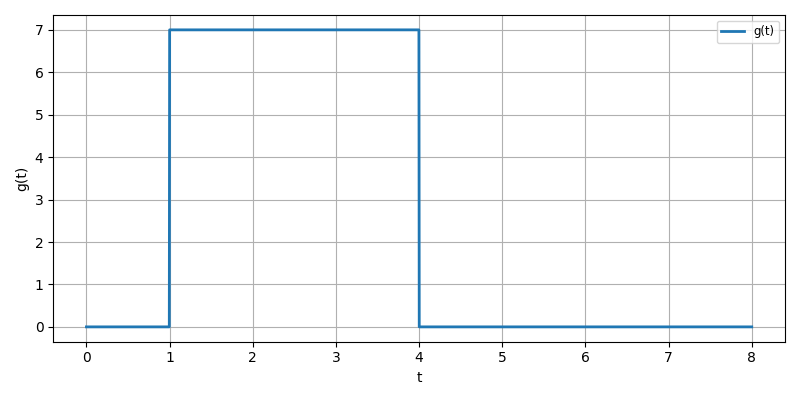

In [ ]:
t_space_1 = np.linspace(0, 8, 2048)
g_1 = [g(t) for t in t_space_1]

draw_plots(1, 1, 8, 4, [[[
    [t_space_1],
    [g_1],
    ['g(t)'],
    't', 'g(t)'
]]])